In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
!wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

--2023-04-15 11:58:51--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 108.158.245.28, 108.158.245.33, 108.158.245.84, ...
Connecting to segment-anything.com (segment-anything.com)|108.158.245.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K   348KB/s    in 0.6s    

2023-04-15 11:58:53 (348 KB/s) - ‘dog.jpg’ saved [221810/221810]



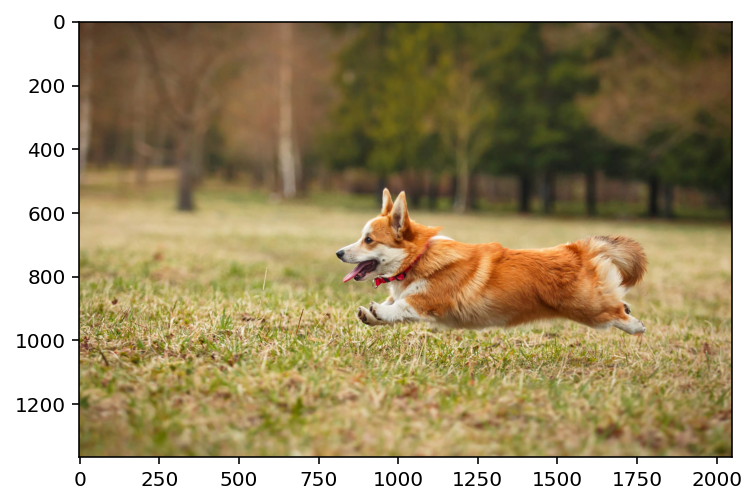

In [2]:
# Read image and convert to RGB
img = plt.imread('dog.jpg')

# Convert to [0, 1] range

img = img / 255


# Plot image
plt.imshow(img)

In [3]:
img.shape

(1365, 2048, 3)

In [4]:
from sklearn.cluster import KMeans

# Reshape image to 2D array
img_2d = img.reshape(-1, 3)
pd.DataFrame(img_2d).describe()


0             1             2
count  2.795520e+06  2.795520e+06  2.795520e+06
mean   5.542249e-01  4.757675e-01  2.935504e-01
std    2.068960e-01  1.844162e-01  1.533922e-01
min    3.921569e-02  0.000000e+00  0.000000e+00
25%    3.882353e-01  3.176471e-01  1.647059e-01
50%    5.725490e-01  4.705882e-01  2.666667e-01
75%    7.294118e-01  6.392157e-01  4.078431e-01
max    1.000000e+00  1.000000e+00  1.000000e+00

In [5]:
img_2d.shape

(2795520, 3)

In [18]:
np.unique(img_2d, axis=0).shape

(190571, 3)

In [6]:
# Fit KMeans from scikit-learn (slow!)
kmeans = KMeans(n_clusters=5, random_state=0).fit(img_2d)

In [7]:
kmeans.cluster_centers_, kmeans.labels_

(array([[0.59260829, 0.48656705, 0.2670584 ],
        [0.24250138, 0.22963615, 0.12538282],
        [0.8270407 , 0.74152134, 0.54547183],
        [0.71622954, 0.62308534, 0.39023071],
        [0.419752  , 0.3354403 , 0.18325719]]),
 array([1, 1, 1, ..., 4, 4, 4], dtype=int32))

In [8]:
# instead use FAISS with GPU

import faiss
# Set up FAISS index
d = img_2d.shape[1]  # Dimension of the feature vectors
n_clusters = 5   # Number of clusters
n_gpus = 2         # Number of GPUs to use

# Initialize a multi-GPU IndexFlatL2 index
index_flat = faiss.IndexFlatL2(d)
index = faiss.index_cpu_to_all_gpus(index_flat, ngpu=n_gpus)

In [9]:
kmeans_gpu = faiss.Clustering(d, n_clusters)
kmeans_gpu.verbose = True
kmeans_gpu.niter = 20
kmeans_gpu.train(img_2d.astype(np.float32), index)

Sampling a subset of 1280 / 2795520 for training
Clustering 1280 points in 3D to 5 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.03 s
  Iteration 19 (0.22 s, search 0.00 s): objective=12.4307 imbalance=1.031 nsplit=0       


In [10]:
_, I = index.search(img_2d.astype(np.float32), 1)  # Search for nearest centroid
cluster_ids = I.squeeze()

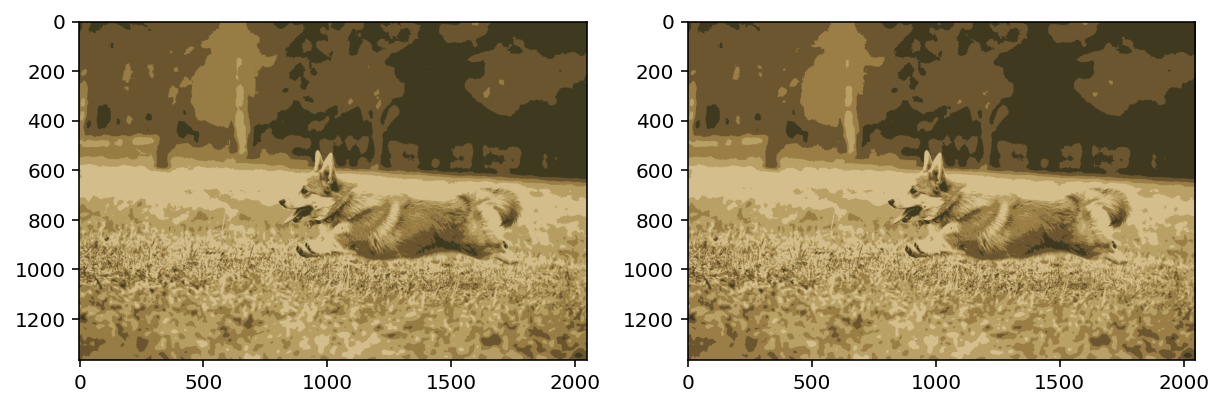

In [11]:
# Create segmented image using cluster centers frmo sklearn
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(img.shape)

centroids_gpu = faiss.vector_float_to_array(kmeans_gpu.centroids).reshape(n_clusters, d)
# Create segmented image using cluster centers from FAISS
segmented_img_faiss = centroids_gpu[cluster_ids]

# Plot segmented image side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(segmented_img)
ax[1].imshow(segmented_img_faiss.reshape(img.shape))

In [12]:
# Now, let's try to segment the image using a different number of clusters using FAISS

def segment_plot(img, k=5):
    # Reshape image to 2D array
    img_2d = img.reshape(-1, 3)

    # Set up FAISS index
    d = img_2d.shape[1]  # Dimension of the feature vectors
    n_clusters = k   # Number of clusters
    n_gpus = 2         # Number of GPUs to use

    # Initialize a multi-GPU IndexFlatL2 index
    index_flat = faiss.IndexFlatL2(d)
    index = faiss.index_cpu_to_all_gpus(index_flat, ngpu=n_gpus)

    kmeans_gpu = faiss.Clustering(d, n_clusters)
    kmeans_gpu.verbose = True
    kmeans_gpu.niter = 20
    kmeans_gpu.train(img_2d.astype(np.float32), index)

    _, I = index.search(img_2d.astype(np.float32), 1)  # Search for nearest centroid
    cluster_ids = I.squeeze()

    centroids_gpu = faiss.vector_float_to_array(kmeans_gpu.centroids).reshape(n_clusters, d)
    # Create segmented image using cluster centers from FAISS
    segmented_img_faiss = centroids_gpu[cluster_ids]

    # Plot segmented image side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[1].imshow(segmented_img_faiss.reshape(img.shape))

    # Plot the color of each cluster
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.imshow(centroids_gpu.reshape(1, n_clusters, 3))
    


Sampling a subset of 512 / 2795520 for training
Clustering 512 points in 3D to 2 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.04 s
  Iteration 19 (0.25 s, search 0.00 s): objective=14.8063 imbalance=1.000 nsplit=0       


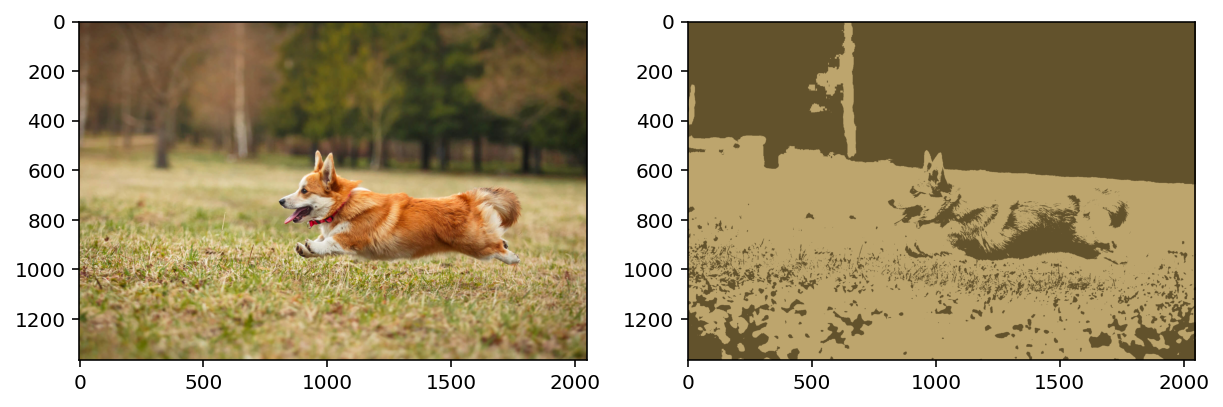

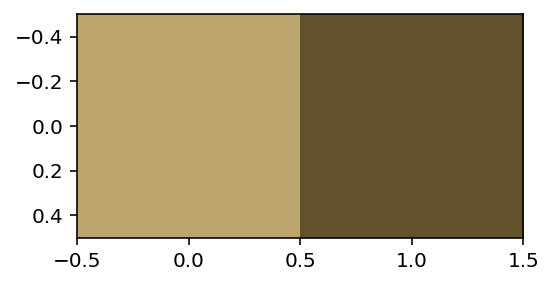

In [13]:
segment_plot(img, k=2)

Sampling a subset of 2560 / 2795520 for training
Clustering 2560 points in 3D to 10 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.04 s
  Iteration 19 (0.03 s, search 0.01 s): objective=13.6225 imbalance=1.202 nsplit=0       


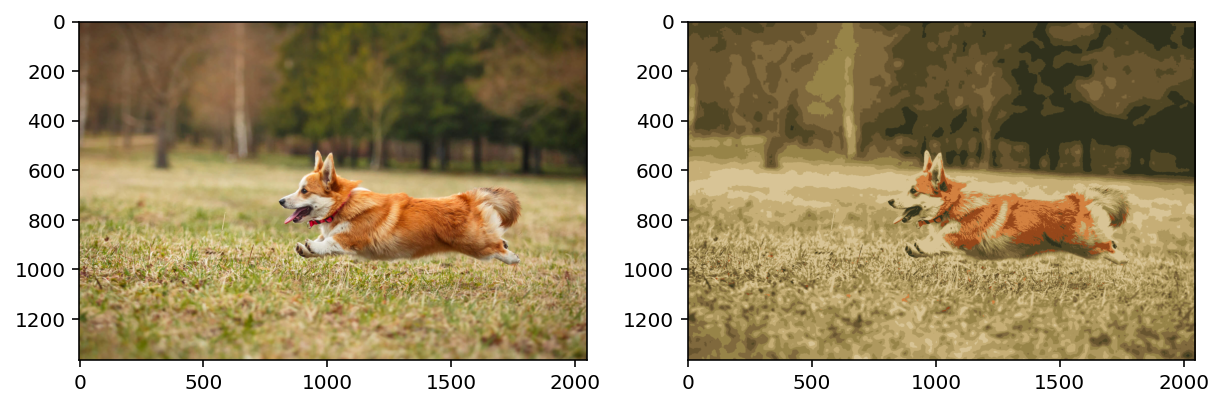

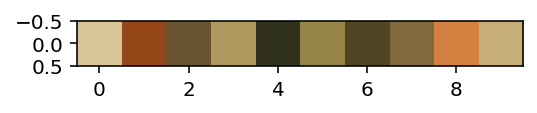

In [14]:
segment_plot(img, k=10)

In [19]:
# Modify segmentation function to mask out all but the given cluster
from copy import deepcopy
def segment_plot_mask(img, k=5):
    # Reshape image to 2D array
    img_2d = img.reshape(-1, 3)

    # Set up FAISS index
    d = img_2d.shape[1]  # Dimension of the feature vectors
    n_clusters = k   # Number of clusters
    n_gpus = 2         # Number of GPUs to use

    # Initialize a multi-GPU IndexFlatL2 index
    index_flat = faiss.IndexFlatL2(d)
    index = faiss.index_cpu_to_all_gpus(index_flat, ngpu=n_gpus)

    kmeans_gpu = faiss.Clustering(d, n_clusters)
    kmeans_gpu.verbose = True
    kmeans_gpu.niter = 20
    kmeans_gpu.train(img_2d.astype(np.float32), index)

    _, I = index.search(img_2d.astype(np.float32), 1)  # Search for nearest centroid
    cluster_ids = I.squeeze()

    centroids_gpu = faiss.vector_float_to_array(kmeans_gpu.centroids).reshape(n_clusters, d)
    # Create segmented image using cluster centers from FAISS
    segmented_img_faiss = centroids_gpu[cluster_ids]

    # Plot segmented image side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    segmented_img_faiss = segmented_img_faiss.reshape(img.shape)
    ax[1].imshow(segmented_img_faiss)

    # Now, create another figure with number of cluser columns
    # and plot each cluster with mask applied to the original image
    # The mask is an alpha channel
    
    fig, ax = plt.subplots(1, n_clusters, figsize=(n_clusters*4, 5))
    for i in range(n_clusters):
        img_masked = deepcopy(img_2d)
        img_masked[cluster_ids != i] = 1.0
        ax[i].imshow(img_masked.reshape(img.shape))
        ax[i].set_title(f'Cluster {i}')
        ax[i].axis('off')
    
    

    

In [59]:
img.shape

(1365, 2048, 3)

Sampling a subset of 512 / 2795520 for training
Clustering 512 points in 3D to 2 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.02 s
  Iteration 19 (0.46 s, search 0.00 s): objective=14.8063 imbalance=1.000 nsplit=0       


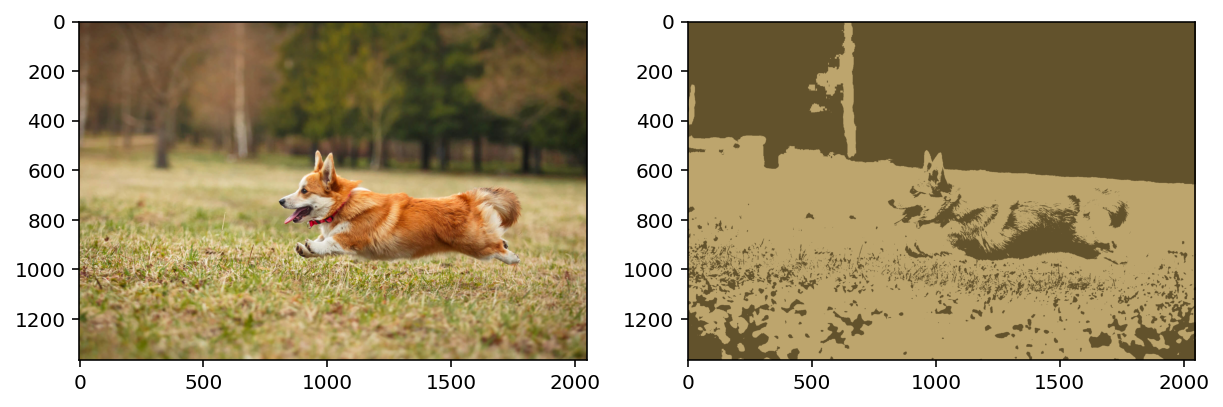

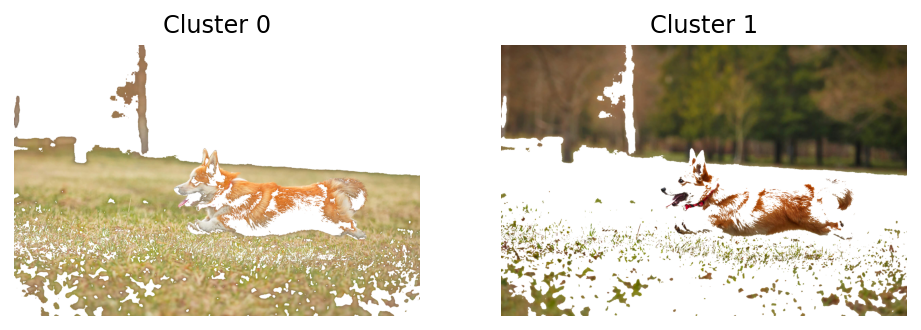

In [20]:
mask = segment_plot_mask(img, k=2)

Sampling a subset of 768 / 2795520 for training
Clustering 768 points in 3D to 3 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.02 s
  Iteration 19 (0.46 s, search 0.00 s): objective=12.5181 imbalance=1.009 nsplit=0       


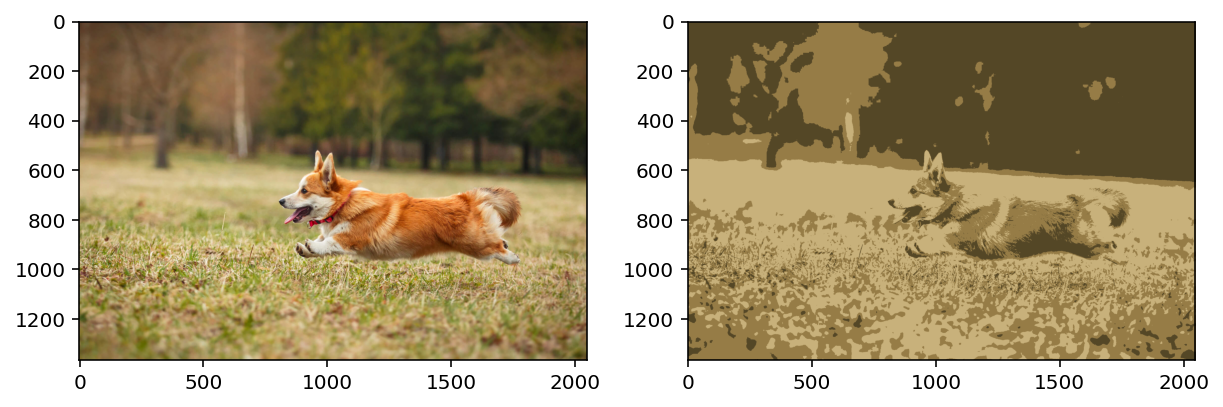

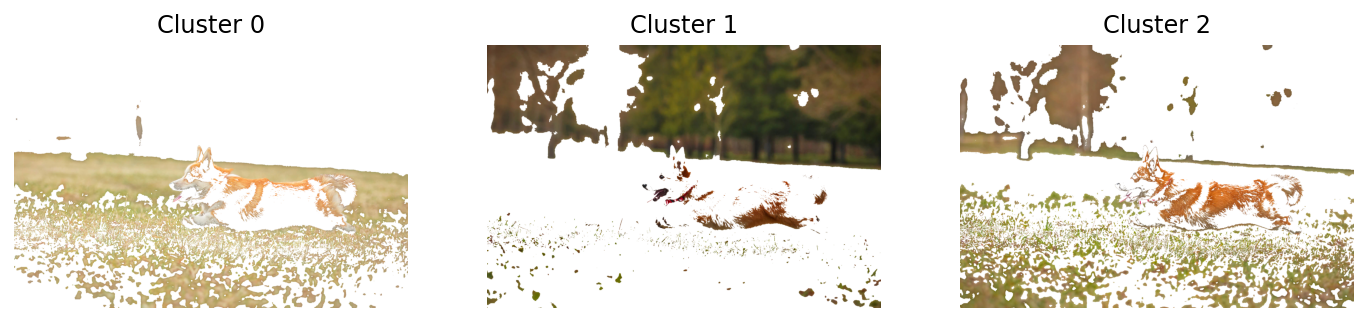

In [61]:
mask = segment_plot_mask(img, k=3)

Sampling a subset of 1024 / 2795520 for training
Clustering 1024 points in 3D to 4 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.02 s
  Iteration 19 (0.15 s, search 0.00 s): objective=12.6442 imbalance=1.031 nsplit=0       


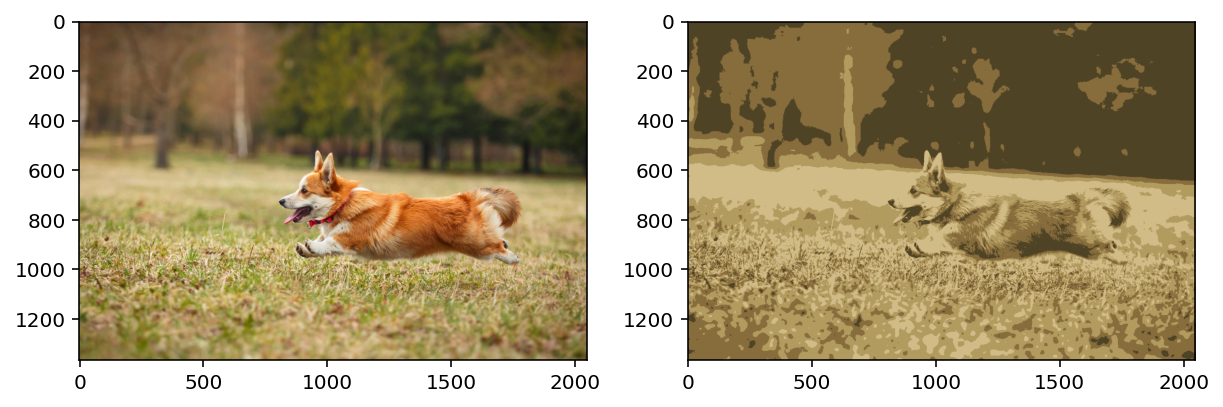

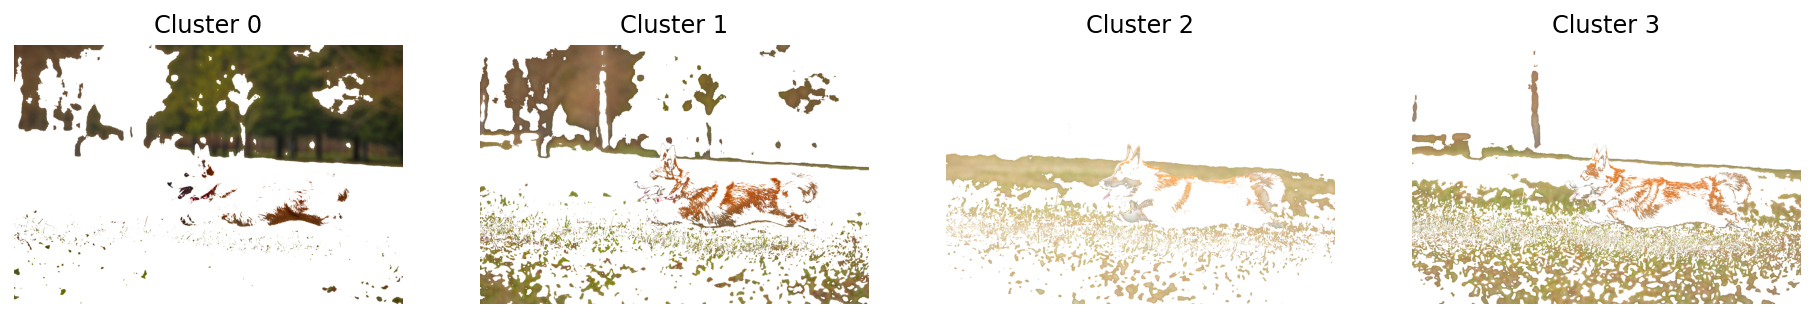

In [62]:
mask = segment_plot_mask(img, k=4)

In [21]:
# Now, let us segment the image using not only RGB but also the spatial coordinates

# Reshape image to 2D array
img_2d = img.reshape(-1, 3)

# Add spatial coordinates
x = np.arange(img.shape[0])
y = np.arange(img.shape[1])

# Scale the spatial coordinates to be between a and b
def scale(x, a, b):
    return (b-a)*(x-x.min())/(x.max()-x.min()) + a

x = scale(x, 0.25, 0.75)
y = scale(y, 0.25, 0.75)

xx, yy = np.meshgrid(x, y)
xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)

img_2d_spatial = np.hstack((img_2d, xx, yy))
pd.DataFrame(img_2d_spatial).describe()

0             1             2             3             4
count  2.795520e+06  2.795520e+06  2.795520e+06  2.795520e+06  2.795520e+06
mean   5.542249e-01  4.757675e-01  2.935504e-01  5.000000e-01  5.000000e-01
std    2.068960e-01  1.844162e-01  1.533922e-01  1.444434e-01  1.444081e-01
min    3.921569e-02  0.000000e+00  0.000000e+00  2.500000e-01  2.500000e-01
25%    3.882353e-01  3.176471e-01  1.647059e-01  3.750000e-01  3.750000e-01
50%    5.725490e-01  4.705882e-01  2.666667e-01  5.000000e-01  5.000000e-01
75%    7.294118e-01  6.392157e-01  4.078431e-01  6.250000e-01  6.250000e-01
max    1.000000e+00  1.000000e+00  1.000000e+00  7.500000e-01  7.500000e-01

In [22]:
# Now, modify the segment_plot function to include spatial coordinates

def segment_plot_spatial(img, k=5):
    # Reshape image to 2D array
    img_2d = img.reshape(-1, 3)

    # Add spatial coordinates
    x = np.arange(img.shape[0])
    y = np.arange(img.shape[1])

    # Scale the spatial coordinates to be between a and b
    x = scale(x, 0, 1)
    y = scale(y, 0, 1)

    xx, yy = np.meshgrid(x, y)
    xx = xx.reshape(-1, 1)
    yy = yy.reshape(-1, 1)

    img_2d_spatial = np.hstack((img_2d, xx, yy))

    # Set up FAISS index
    d = img_2d_spatial.shape[1]  # Dimension of the feature vectors
    n_clusters = k   # Number of clusters
    n_gpus = 2         # Number of GPUs to use

    # Initialize a multi-GPU IndexFlatL2 index
    index_flat = faiss.IndexFlatL2(d)
    index = faiss.index_cpu_to_all_gpus(index_flat, ngpu=n_gpus)

    kmeans_gpu = faiss.Clustering(d, n_clusters)
    kmeans_gpu.verbose = True
    kmeans_gpu.niter = 20    
    kmeans_gpu.train(img_2d_spatial.astype(np.float32), index)

    _, I = index.search(img_2d_spatial.astype(np.float32), 1)  # Search for nearest centroid
    cluster_ids = I.squeeze()

    centroids_gpu = faiss.vector_float_to_array(kmeans_gpu.centroids).reshape(n_clusters, d)
    # Create segmented image using cluster centers from FAISS with spatial coordinates excluded for plotting
    segmented_img_faiss = centroids_gpu[cluster_ids, :3]

    # Plot segmented image side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[1].imshow(segmented_img_faiss.reshape(img.shape))

    # Now, create another figure with number of cluser columns
    # and plot each cluster with mask applied to the original image
    # The mask is an alpha channel
    
    fig, ax = plt.subplots(1, n_clusters, figsize=(n_clusters*4, 5))
    for i in range(n_clusters):
        img_masked = deepcopy(img_2d_spatial[:, :3 ])
        img_masked[cluster_ids != i] = 1.0
        ax[i].imshow(img_masked.reshape(img.shape))
        ax[i].set_title(f'Cluster {i}')
        ax[i].axis('off')

Sampling a subset of 512 / 2795520 for training
Clustering 512 points in 5D to 2 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.03 s
  Iteration 19 (0.44 s, search 0.00 s): objective=73.9492 imbalance=1.018 nsplit=0       


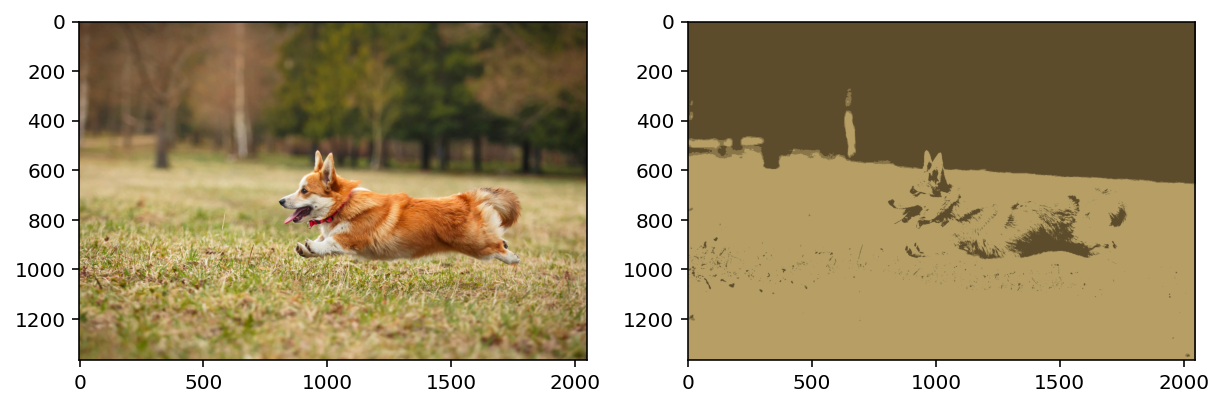

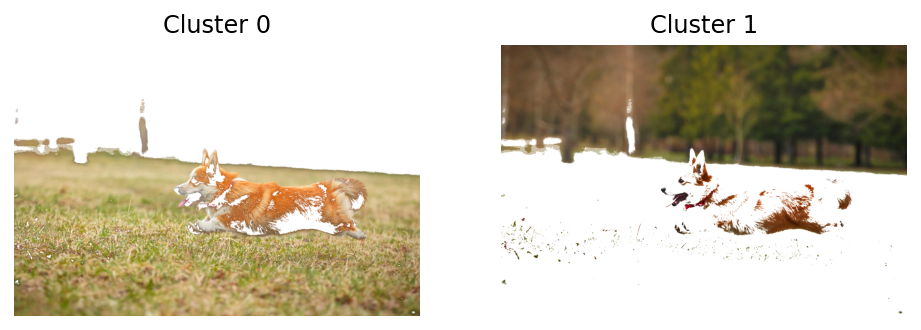

In [23]:
segment_plot_spatial(img, k=2)

Sampling a subset of 512 / 2795520 for training
Clustering 512 points in 3D to 2 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.03 s
  Iteration 19 (0.47 s, search 0.00 s): objective=14.8063 imbalance=1.000 nsplit=0       


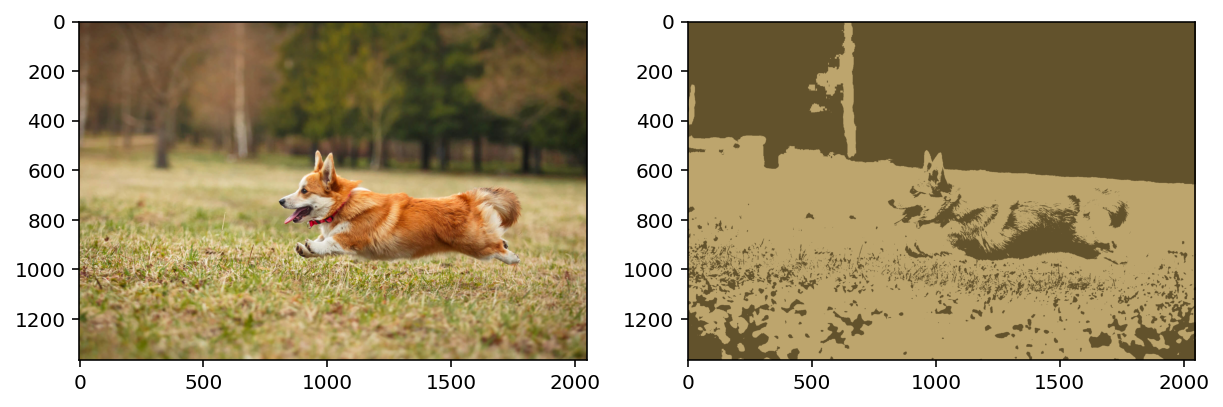

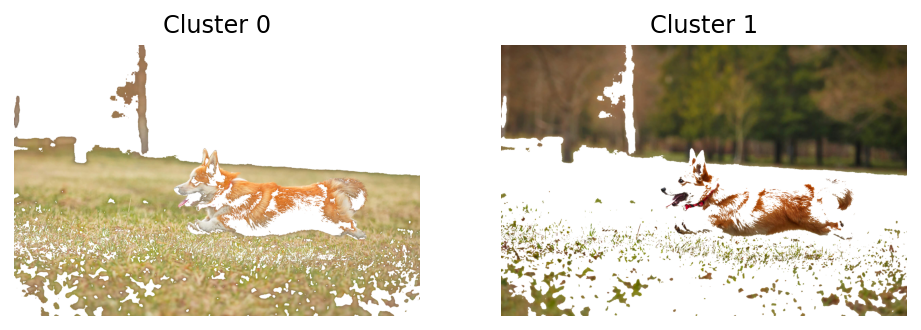

In [24]:
segment_plot_mask(img, k=2)